In [2]:
import IPython
from IPython.display import display, HTML, SVG, Image
import graphviz
from graphviz import Source
from io import StringIO
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [10, 6] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

import pydotplus
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn import tree
from sklearn.metrics import * 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
# Feature importance
import shap
import matplotlib.pyplot as plt
# load JS visualization code to notebook
shap.initjs()

In [3]:
#########################
#  Confusion Matrix
#########################
def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    # Set font size for the plots. You can ignore this line.
    PLOT_FONT_SIZE = 14
    # Set plot size. Please ignore this line
    plt.rcParams['figure.figsize'] = [5, 5]
    # Transpose of confusion matrix to align the plot with the actual precision recall values. Please ignore this as well.
    confusionMatrix = np.transpose(confusionMatrix)
    # Plotting the confusion matrix
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    
    # Setting plot properties. You should ignore everything from here on.
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Leave\nRecall=" + str(recallNegative) , "Stay\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Leave\nPrecision=" + str(precisionNegative) , "Stay\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
        
    # Add text in heatmap boxes
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap
            
    plt.show()


#########################
# Calc/Print Metrics
#########################
def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    
    # Print metrics. .%2f prints a number upto 2 decimal points only.
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f\n" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    
    # Display confusion matrix
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    
    return auc

#########################
# Feature  Importance
#########################
def showFeatureImportance(classifier, columns):
    columns = columns[:-1]
    print(columns)
    
    # Plot size and font size
    plt.rcParams['figure.figsize'] = [16, 6]
    PLOT_FONT_SIZE = 14
    
    # Get feature importance values
    featureImportance = classifier.feature_importances_
    featureImportanceWithColumns = list(reversed(sorted([[featureImportance[i], columns[i]] for i in range(0, len(columns))])))
    sortedColumns = [item[1] for item in featureImportanceWithColumns]
    sortedFeatures = [item[0] for item in featureImportanceWithColumns]
    
    
    # Plotting
    xaxis = np.arange(len(featureImportance))
    plt.bar(xaxis, sortedFeatures, width = 0.5, color = 'white', hatch = '//', edgecolor = '#8a4191', linewidth = 2.0)
    plt.xticks(xaxis, sortedColumns, fontsize = PLOT_FONT_SIZE, rotation = 45)
    plt.yticks(fontsize = PLOT_FONT_SIZE)
    plt.xlabel("Feature Name",fontsize = PLOT_FONT_SIZE)
    plt.ylabel("Feature Importance",fontsize = PLOT_FONT_SIZE)
    plt.title("Feature Importances", fontsize = PLOT_FONT_SIZE)
    plt.show()
    
    # Table
    importanceDataFrame = pd.DataFrame(featureImportanceWithColumns)
    display(importanceDataFrame)
#################
# From DS1
#################
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))
########
# https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf
#######
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()

########
# https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf
#######
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()


In [4]:
# Read data into a data frame
data = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Train.csv", ","))
# Delete null values
data = data.dropna()
# Get column names. We will use these for visualization purposes
columns = list(data.columns)
# Display the data frame as a table
display(data)

,AnonymousID,HotelInncode,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,LearningDevelopment,Communication,Voice,RewardsBenefits,WorkEnvironment,IntentToStay
0,22684,100234,11,4,1,24,1,6,2,4.5,4.67,4.67,5.0,5.0,4.50,1
1,38792,100100,11,4,1,12,1,5,4,2.0,2.33,4.00,3.5,2.5,4.00,0
2,23552,100246,3,2,3,20,1,8,1,5.0,5.00,5.00,5.0,5.0,5.00,1
3,10801,100209,10,5,1,21,1,8,2,4.5,2.67,2.00,2.5,4.0,2.50,1
4,18343,100099,4,3,2,38,1,8,1,5.0,4.67,4.67,5.0,5.0,5.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,31739,100281,6,3,2,21,1,2,2,3.0,3.00,5.00,3.0,4.0,4.50,0
4796,18126,100078,11,4,1,28,1,5,1,3.0,4.00,3.00,2.0,3.0,4.25,0
4797,28158,100158,3,2,1,7,1,5,1,5.0,5.00,4.33,5.0,5.0,4.75,1
4798,29268,100252,6,3,2,7,1,7,2,4.5,3.67,5.00,4.0,4.5,4.50,1


In [5]:
data.describe( )

,AnonymousID,HotelInncode,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,LearningDevelopment,Communication,Voice,RewardsBenefits,WorkEnvironment,IntentToStay
count,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000
mean,20145.133750,100188.640625,6.006667,3.012708,1.878333,17.722708,0.878333,5.901458,2.143750,4.329063,4.089387,4.260598,4.129479,4.264167,4.341927,0.546042
std,11402.822283,64.118803,2.565653,0.674333,0.804621,8.667024,0.326934,1.969151,0.910087,0.800799,0.929284,0.912750,1.010909,0.785633,0.757885,0.497928
min,8.000000,100063.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,10463.500000,100143.000000,4.000000,3.000000,1.000000,12.000000,1.000000,5.000000,2.000000,4.000000,3.670000,4.000000,3.500000,4.000000,4.000000,0.000000
50%,20251.000000,100196.000000,6.000000,3.000000,2.000000,21.000000,1.000000,6.000000,2.000000,4.500000,4.000000,4.670000,4.500000,4.500000,4.500000,1.000000
75%,29866.000000,100242.000000,6.000000,3.000000,3.000000,21.000000,1.000000,8.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000
max,39874.000000,100307.000000,11.000000,5.000000,3.000000,42.000000,1.000000,8.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


In [6]:
columns

['AnonymousID',
 'HotelInncode',
 'HotelBrand',
 'HotelChainScale',
 'Generation',
 'Department',
 'FullTimePartTime',
 'Tenure',
 'ManagementLevel',
 'WorkLifeBalance',
 'LearningDevelopment',
 'Communication',
 'Voice',
 'RewardsBenefits',
 'WorkEnvironment',
 'IntentToStay']

In [7]:
summarize_dataframe(data)

,Data Type,Missing Values,Unique Values,count,mean,std,min,25%,50%,75%,max
Variable Name,,,,,,,,,,,
AnonymousID,int64,0,4800,4800.0,20145.133750,11402.822283,8.0,10463.50,20251.00,29866.0,39874.0
HotelInncode,int64,0,228,4800.0,100188.640625,64.118803,100063.0,100143.00,100196.00,100242.0,100307.0
HotelBrand,int64,0,11,4800.0,6.006667,2.565653,1.0,4.00,6.00,6.0,11.0
HotelChainScale,int64,0,5,4800.0,3.012708,0.674333,1.0,3.00,3.00,3.0,5.0
Generation,int64,0,3,4800.0,1.878333,0.804621,1.0,1.00,2.00,3.0,3.0
Department,int64,0,40,4800.0,17.722708,8.667024,1.0,12.00,21.00,21.0,42.0
FullTimePartTime,int64,0,2,4800.0,0.878333,0.326934,0.0,1.00,1.00,1.0,1.0
Tenure,int64,0,8,4800.0,5.901458,1.969151,1.0,5.00,6.00,8.0,8.0
ManagementLevel,int64,0,4,4800.0,2.143750,0.910087,1.0,2.00,2.00,2.0,4.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63ca7d56d0>,
      dtype=object)

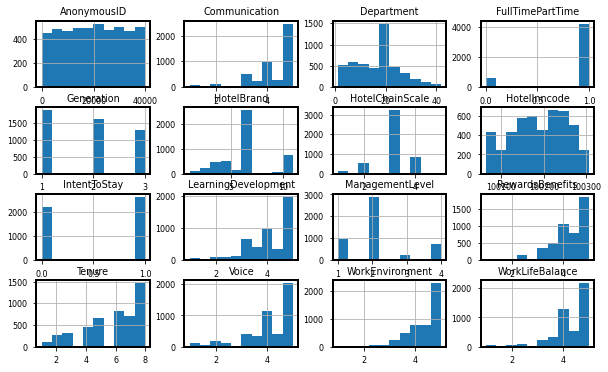

In [8]:
data.hist()

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


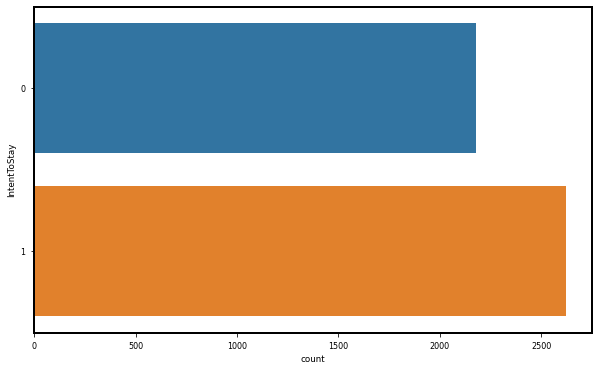

In [9]:
c_palette = ['tab:blue', 'tab:orange']
categorical_summarized(data, y = 'IntentToStay', palette=c_palette)

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


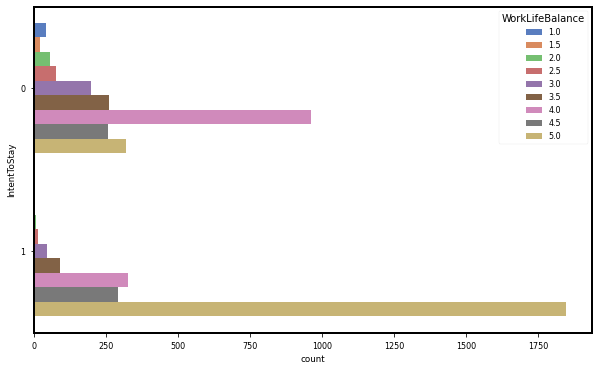

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


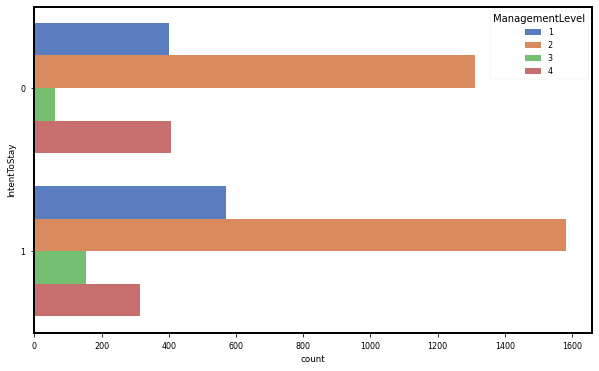

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


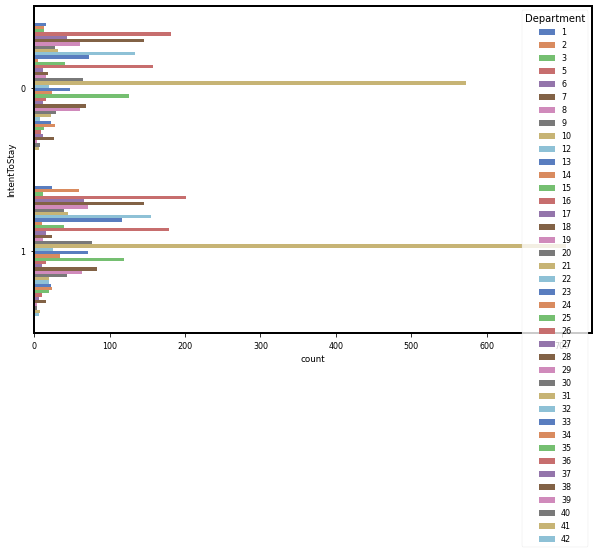

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


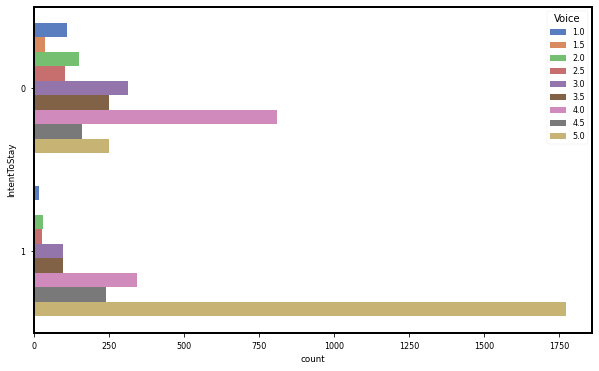

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


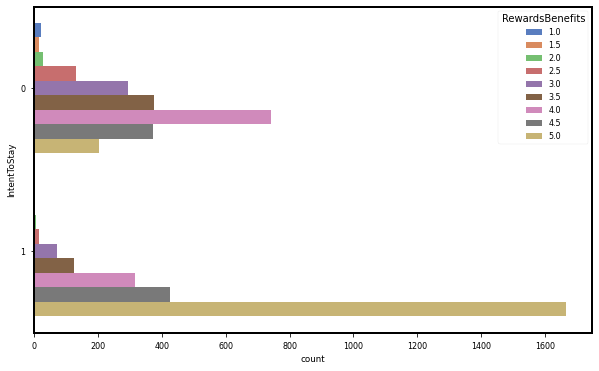

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


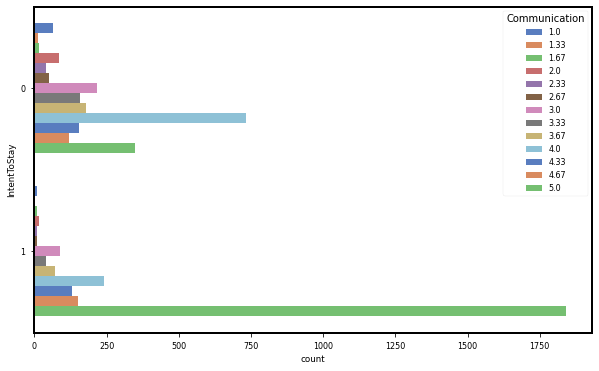

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


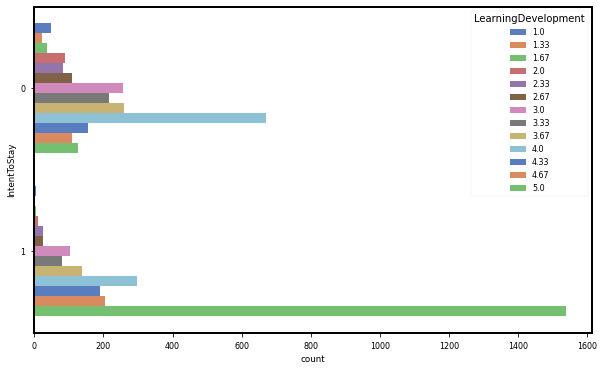

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


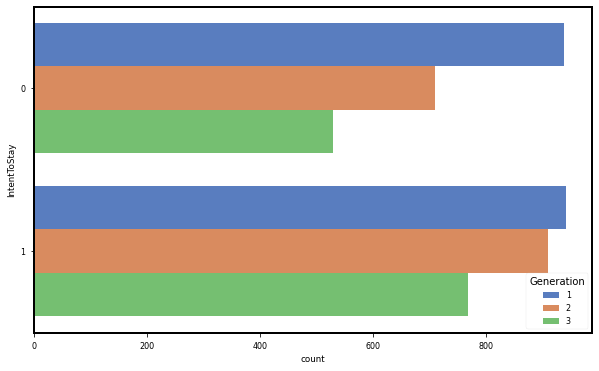

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


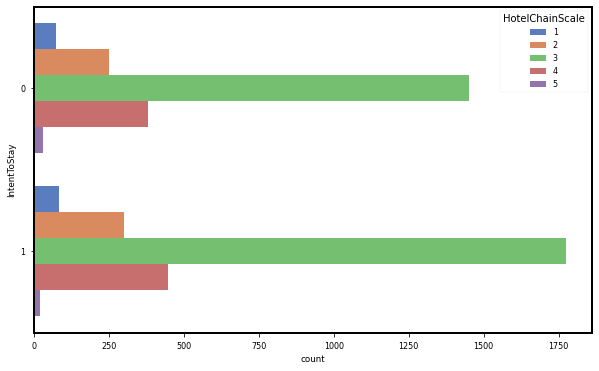

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


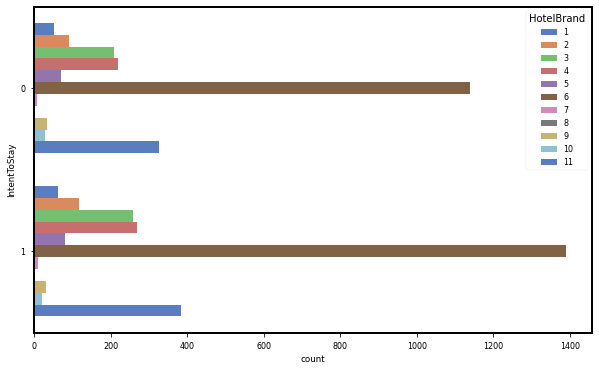

In [10]:
categorical_summarized(data, y = 'IntentToStay', hue='WorkLifeBalance', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='ManagementLevel', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='Department', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='Voice', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='RewardsBenefits', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='Communication', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='LearningDevelopment', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='Generation', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='HotelChainScale', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='HotelBrand', palette="muted")


In [11]:
columns

['AnonymousID',
 'HotelInncode',
 'HotelBrand',
 'HotelChainScale',
 'Generation',
 'Department',
 'FullTimePartTime',
 'Tenure',
 'ManagementLevel',
 'WorkLifeBalance',
 'LearningDevelopment',
 'Communication',
 'Voice',
 'RewardsBenefits',
 'WorkEnvironment',
 'IntentToStay']

In [12]:
corrcols = ['IntentToStay'] + columns[2:-1]
df = data[corrcols]
correlations = df.corr()
print (correlations)

                     IntentToStay  HotelBrand  HotelChainScale  Generation  \
IntentToStay             1.000000   -0.013779        -0.007639    0.075357   
HotelBrand              -0.013779    1.000000         0.583732   -0.007177   
HotelChainScale         -0.007639    0.583732         1.000000   -0.005983   
Generation               0.075357   -0.007177        -0.005983    1.000000   
Department              -0.026229    0.095010         0.046846    0.016436   
FullTimePartTime         0.039538   -0.018161         0.030644    0.102935   
Tenure                   0.042351    0.036220         0.075169    0.458656   
ManagementLevel         -0.074387   -0.014778        -0.000261    0.070557   
WorkLifeBalance          0.515025   -0.042194        -0.036687    0.030617   
LearningDevelopment      0.530487   -0.015329        -0.024708    0.024636   
Communication            0.478130   -0.017535        -0.046363    0.024645   
Voice                    0.521040   -0.039539        -0.058200  

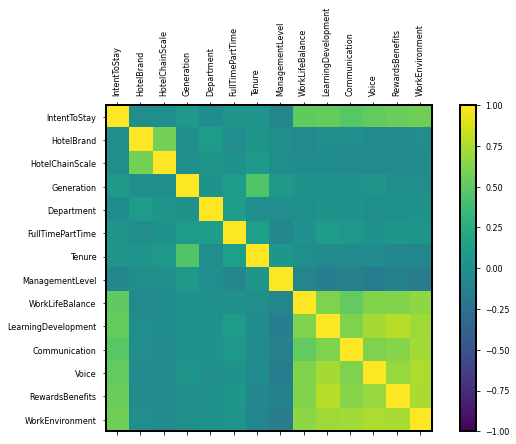

In [13]:


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, interpolation='nearest', vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 14, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corrcols, rotation=90)
ax.set_yticklabels(corrcols)
plt.show()


In [14]:
correlations.style.background_gradient(cmap='coolwarm').set_precision(2)


,IntentToStay,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,LearningDevelopment,Communication,Voice,RewardsBenefits,WorkEnvironment
IntentToStay,1.00,-0.01,-0.01,0.08,-0.03,0.04,0.04,-0.07,0.52,0.53,0.48,0.52,0.54,0.57
HotelBrand,-0.01,1.00,0.58,-0.01,0.10,-0.02,0.04,-0.01,-0.04,-0.02,-0.02,-0.04,-0.04,-0.01
HotelChainScale,-0.01,0.58,1.00,-0.01,0.05,0.03,0.08,-0.00,-0.04,-0.02,-0.05,-0.06,-0.05,-0.05
Generation,0.08,-0.01,-0.01,1.00,0.02,0.10,0.46,0.07,0.03,0.02,0.02,0.03,-0.00,-0.02
Department,-0.03,0.10,0.05,0.02,1.00,0.11,-0.02,-0.02,-0.00,0.03,0.01,-0.00,0.00,0.02
FullTimePartTime,0.04,-0.02,0.03,0.10,0.11,1.00,0.13,-0.08,0.01,0.10,0.07,0.03,0.06,0.04
Tenure,0.04,0.04,0.08,0.46,-0.02,0.13,1.00,0.05,-0.00,-0.03,-0.04,-0.03,-0.07,-0.08
ManagementLevel,-0.07,-0.01,-0.00,0.07,-0.02,-0.08,0.05,1.00,-0.09,-0.13,-0.13,-0.15,-0.12,-0.15
WorkLifeBalance,0.52,-0.04,-0.04,0.03,-0.00,0.01,-0.00,-0.09,1.00,0.61,0.52,0.62,0.62,0.66
LearningDevelopment,0.53,-0.02,-0.02,0.02,0.03,0.10,-0.03,-0.13,0.61,1.00,0.61,0.73,0.78,0.72


# Feature and Label Vectors

In [15]:
# Change to run gridcv
train=False

In [16]:
# dataDT = data[['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment','FullTimePartTime', 'ManagementLevel','Tenure','Generation','IntentToStay']]

dataDT = data[['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment','Tenure', 'HotelBrand', 'IntentToStay']]

In [17]:
dtCols = list(dataDT.columns)
dtCols
# Convert data to a list of lists
dataList = dataDT.values.tolist()
print(dtCols)

# Get features
features = []

# Iterate over each row
for row in dataList:
    
    # Skip the first two columns because they are not needed and the last column because that's the label
    featureValues = row[:-1]

    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    
    # Append the features to the feature list
    features.append(featureValues)
    
# Get labels from the data
labels = [row[-1] for row in dataList]

# Label distribution for Leave and Stay respectively
print("Label distribution of 0 and 1", labels.count(0), labels.count(1))

# Test data percentage (0.1 = 10%)
# Note - since the final test set is the blinded Kaggle data, this is essentially a validation set for parameter tuning
TEST_DATA_PERCENTAGE = 0.1

# Split into train and test
trainData, testData, trainLabels, testLabels = train_test_split(features, labels, test_size=TEST_DATA_PERCENTAGE)

['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment', 'Tenure', 'HotelBrand', 'IntentToStay']
Label distribution of 0 and 1 2179 2621


In [18]:
from sklearn.model_selection import GridSearchCV

# 5.3 Advanced Stuff: XgBoost
XgBoost (Gradient Boosted Trees) is the most widely used machine learning algorithm in the industry these days. It is a powerful algorithm that mixes decision trees, random forests, boosting, and gradients to come up effective classifiers for our data sets. Plenty of kaggle competitions have been won by using this algorithm.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier


In [20]:
## ## 4.2 Feature and Label Vectors  ##
# dataGB = data[['Department',  'Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice','Generation', 'RewardsBenefits', 'WorkEnvironment', 'IntentToStay']]
dataGB = data[['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment','Tenure','Generation','IntentToStay']]
gbCols = list(dataGB.columns)
gbCols
# Convert data to a list of lists1
dataList = dataGB.values.tolist()

# Get features
features = []

# Iterate over each row
for row in dataList:
    
    # Skip the first two columns because they are not needed and the last column because that's the label
    featureValues = row[:-1]

    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    
    # Append the features to the feature list
    features.append(featureValues)
    
# Get labels from the data
labels = [row[-1] for row in dataList]

# Label distribution for Leave and Stay respectively
print("Label distribution of 0 and 1", labels.count(0), labels.count(1))

# Test data percentage (0.1 = 10%)
# Note - since the final test set is the blinded Kaggle data, this is essentially a validation set for parameter tuning
TEST_DATA_PERCENTAGE = 0.1

# Split into train and test
trainData, testData, trainLabels, testLabels = train_test_split(features, labels, test_size=TEST_DATA_PERCENTAGE)

Label distribution of 0 and 1 2179 2621


## 5.3.1 Grid Search on XgBoost
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [21]:
set_background('#ffffff')
#####################################################################################################################################################
# Things you can change                                                                                                                             #
#####################################################################################################################################################
# GridSearchCV function takes in a parameter dictionary which is very important here. 
# The dictionary contains as keys the parameter names and values are the possible values of the parameter that you want to test
parameters = {'loss': ["deviance", "exponential"],
            'max_depth': [2,3, 4,5],
            'min_impurity_decrease': [0,.1,.05],
            'learning_rate': [.005,0.1,0.15],
            'n_estimators': [50,100,150,200],
            'max_features':['None',.8,.7,.6],
            'subsample': [.6,.7,.85,1.0]} 

# parameters = {'max_depth': [2,3, 4,5],
#             'min_impurity_decrease': [0,.8,.7],
#             'learning_rate': [.005,0.1,0.15],
#             'n_estimators': [50,60,80,100],
#             'max_features':['None',.8,],
#             'subsample': [.85,1.0]} 

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_
#####################################################################################################################################################

In [22]:
parameters = {'max_depth': [3,4],
            'min_impurity_decrease': [0,.1,.05,.5,.7],
            'learning_rate': [.01,0.1,0.15],
            'n_estimators': [80,150,250,350],
            'max_features':['None',.8,],
            'subsample': [.85,1.0]} 

In [23]:

if (train) :
    gbClassifierWithGridSearch = GridSearchCV(GradientBoostingClassifier(),scoring='roc_auc', cv=5, param_grid=parameters, n_jobs=6, verbose=1)

    # Train the decision tree model using the function .fit
    gbClassifierWithGridSearch.fit(trainData, trainLabels)

    # Calculate training accuracy of the classifier
    # trainAccuracy = gbClassifierWithGridSearch.score(trainData, trainLabels)

    # Predict on test data
    # predictions = gbClassifierWithGridSearch.predict(testData) # This will give binary labels e.g 0/1
    # predictionProbabilities = gbClassifierWithGridSearch.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 0 and 0.7 for 1.
    print("Best Parameters are: ", gbClassifierWithGridSearch.best_params_)

In [24]:
gbClassifier = GradientBoostingClassifier(learning_rate= 0.001, max_depth= 3, max_features=.7,min_impurity_decrease=.7, n_estimators= 350, subsample= .85, random_state = 1)
gbClassifier.fit(trainData, trainLabels)
trainAccuracy = gbClassifier.score(trainData, trainLabels)
predictions = gbClassifier.predict(testData) 
predictionProbabilities = gbClassifier.predict_proba(testData) 

Accuracy: 80.42
PrecisionNegative: 80.85
PrecisionPositive: 80.14
RecallNegative: 72.38
RecallPositive: 86.67
AUC Score: 88.80



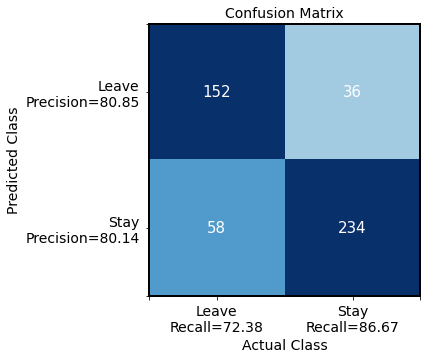

In [25]:
# Calculate metrics on test set and display them
gbtGridAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateGbWithGridSearch, truePositiveRateGbWithGridSearch, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

# Unfortunately, Feature importance does not work with GridSearch. Instead, we will find the best parameters.


['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment', 'Tenure', 'Generation']


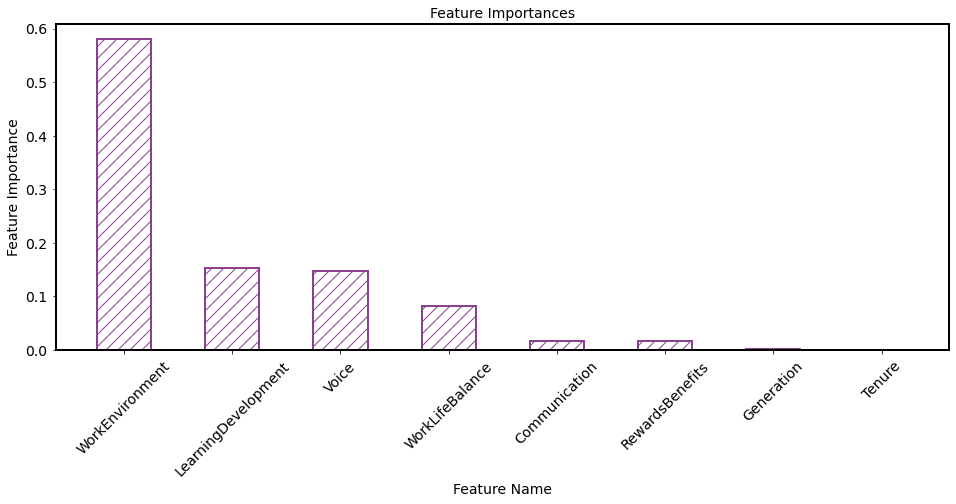

,0,1
0,0.579908,WorkEnvironment
1,0.153812,LearningDevelopment
2,0.147185,Voice
3,0.082657,WorkLifeBalance
4,0.016657,Communication
5,0.016402,RewardsBenefits
6,0.002721,Generation
7,0.000658,Tenure


In [26]:
columns=list(dataGB.columns)
showFeatureImportance(gbClassifier, columns)

# Random Forrest

In [27]:
if train :
    parameters = {'n_estimators': [400, 550],
                'max_features': ['auto',.7,.9],
                'min_samples_leaf': [25,50,75],
                'min_impurity_decrease': [0,.3]
                }


    rf_tuned = GridSearchCV(RandomForestClassifier(random_state=201,
                            ccp_alpha=10),param_grid=parameters, cv=4, n_jobs=6, verbose=1)
    rf_tuned.fit(trainData, trainLabels)
    rf_tuned.best_params_

In [29]:
if train:
    rf_tuned.best_params_

Accuracy: 82.08
PrecisionNegative: 76.72
PrecisionPositive: 87.10
RecallNegative: 84.76
RecallPositive: 80.00
AUC Score: 89.71



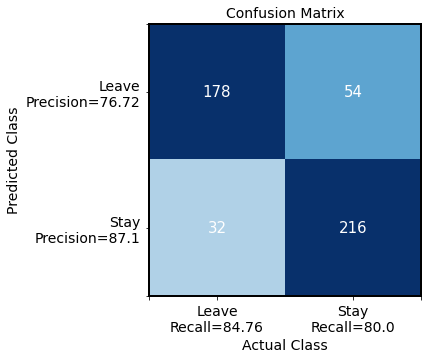

In [30]:

# rfClassifier = RandomForestClassifier(random_state=201, max_features='auto', min_samples_leaf=4, n_estimators=350, ccp_alpha=0) 92 AUC
rfClassifier = RandomForestClassifier(random_state=201, max_features='auto', min_samples_leaf=25, n_estimators=400,min_impurity_decrease=0, ccp_alpha=0)
rfClassifier.fit(trainData, trainLabels)
predictions = rfClassifier.predict(testData)
predictionProbabilities = rfClassifier.predict_proba(testData)

# Calculate metrics on test set and display them
rfAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateRF, truePositiveRateRF, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
trainAccuracy = gbClassifier.score(trainData, trainLabels)
# Unfortunately, Feature importance does not work with GridSearch. Instead, we will find the best parameters.


['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment', 'Tenure', 'Generation']


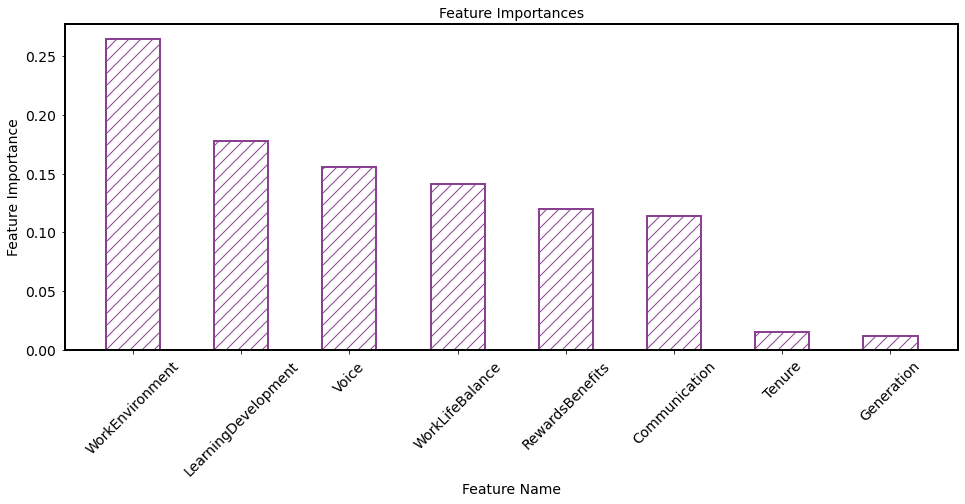

,0,1
0,0.264267,WorkEnvironment
1,0.177688,LearningDevelopment
2,0.155852,Voice
3,0.141565,WorkLifeBalance
4,0.119719,RewardsBenefits
5,0.113723,Communication
6,0.014920,Tenure
7,0.012265,Generation


In [31]:
columns=list(dataGB.columns)
showFeatureImportance(rfClassifier, columns)

# Logistic Regression

In [32]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [33]:
xDat = data[['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment','ManagementLevel','Generation']]
lrCols = list(xDat.columns)
yDat = data[['IntentToStay']]

clf = LogisticRegression(solver='liblinear', random_state=0)

x= dict(C = np.logspace(-4, 4, 50), penalty = ['l1', 'l2'])
clfGS = GridSearchCV(clf, cv=5, param_grid=x, verbose=True, n_jobs=6)
clfGS.fit(xDat, yDat)
clfGS.best_estimator_.get_params()

predictions = clfGS.predict(testData)
predictionProbabilities = clfGS.predict_proba(xDat)

clfGS.best_estimator_.get_params()



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    7.0s finished


{'C': 16.768329368110066,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Accuracy: 81.67
PrecisionNegative: 79.61
PrecisionPositive: 83.21
RecallNegative: 78.10
RecallPositive: 84.44
AUC Score: 88.34



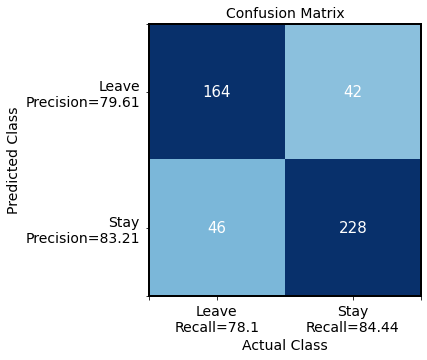

In [35]:
clf = LogisticRegression(solver='liblinear', random_state=0, C=16.768329368110066, penalty='l1').fit(xDat, yDat)

predictions = clf.predict(testData)
predictionProbabilities = clf.predict_proba(testData)



# Calculate metrics on test set and display them
lrAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateLR, truePositiveRateLR, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
trainAccuracy = gbClassifier.score(trainData, trainLabels)


# SVC

In [36]:
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV



In [37]:
# clf = LinearSVC()
# model = CalibratedClassifierCV(clf) 
# model.fit(xDat, yDat)


# predictions = model.predict(testData)
# predictionProbabilities = model.predict_proba(testData)

# # # Calculate metrics on test set and display them
# svcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # # Calculate FPR and TPR for use in ROC Curve Variance later on
# falsePositiveRateSVC, truePositiveRateSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])


In [69]:
train = True
if train:
    param_grid = {'C': [0.5, .1, 1, 5, 10],  
                'gamma': [1, 0.1, 0.01, 0.001, 10], 
                'kernel': ['linear' ]}  
    
    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose=5, n_jobs=8) 
    
    # fitting the model for grid search 
    grid.fit(xDat, yDat) 

    # print best parameter after tuning 
    print(grid.best_params_) 
    
    # print how our model looks after hyper-parameter tuning 
    print(grid.best_estimator_) 


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:   10.9s finished
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=0.1, gamma=1, kernel='linear')


In [64]:
mySVC = SVC(C=1, gamma=.01, kernel='rbf', probability=True)
# mySVC = SVC(C=1, gamma=0.1, kernel='poly', degree=3, probability=True)
mySVC.fit(xDat, yDat) 


SVC(C=1, gamma=0.01, probability=True)

In [77]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [80]:
lrCols

['WorkLifeBalance',
 'RewardsBenefits',
 'Communication',
 'LearningDevelopment',
 'Voice',
 'WorkEnvironment',
 'ManagementLevel',
 'Generation']

              precision    recall  f1-score   support

         0.0       0.78      0.85      0.81       210
         1.0       0.87      0.82      0.85       270

    accuracy                           0.83       480
   macro avg       0.83      0.83      0.83       480
weighted avg       0.83      0.83      0.83       480

Accuracy: 83.12
PrecisionNegative: 78.41
PrecisionPositive: 87.35
RecallNegative: 84.76
RecallPositive: 81.85
AUC Score: 88.16



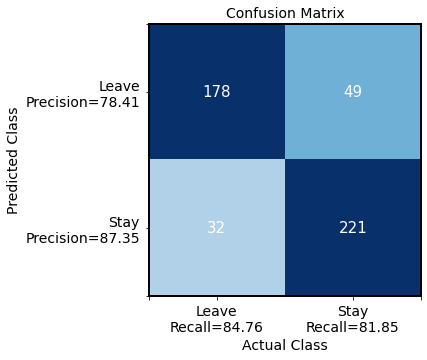

In [83]:
myLinearSVC = SVC(C=0.1, gamma=1, kernel='linear', probability=True)

myLinearSVC.fit(xDat, yDat) 

predictions = myLinearSVC.predict(testData)
print(classification_report(testLabels, predictions)) 
predictionProbabilities = myLinearSVC.predict_proba(testData)

# # Calculate metrics on test set and display them
linearSvcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateSVC, truePositiveRateSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
# columns=list(dataGB.columns)

              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       210
         1.0       0.82      0.85      0.84       270

    accuracy                           0.81       480
   macro avg       0.81      0.81      0.81       480
weighted avg       0.81      0.81      0.81       480

Accuracy: 81.46
PrecisionNegative: 80.10
PrecisionPositive: 82.44
RecallNegative: 76.67
RecallPositive: 85.19
AUC Score: 89.18



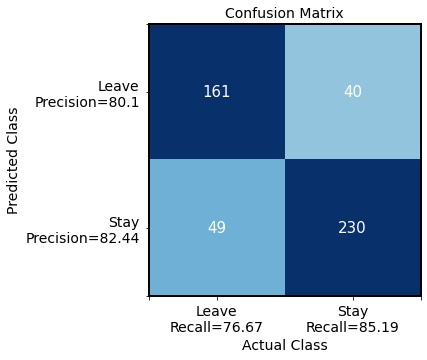

In [84]:

predictions = mySVC.predict(testData)
print(classification_report(testLabels, predictions)) 
predictionProbabilities = mySVC.predict_proba(testData)

# # Calculate metrics on test set and display them
svcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateLinearSVC, truePositiveRateLinearSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

# Results

In [85]:
print("AUC values for different classifiers...")
print("Gradient Boosted Trees: %.3f\nRandom Forrest: %.3f\nLogistic Reg: %.3f\nSVC: %.3f\nLinear SVC: %.3f" % (gbtGridAUC,rfAUC,lrAUC,svcAUC,linearSvcAUC))

AUC values for different classifiers...
Gradient Boosted Trees: 88.800
Random Forrest: 89.710
Logistic Reg: 88.340
SVC: 89.180
Linear SVC: 88.160


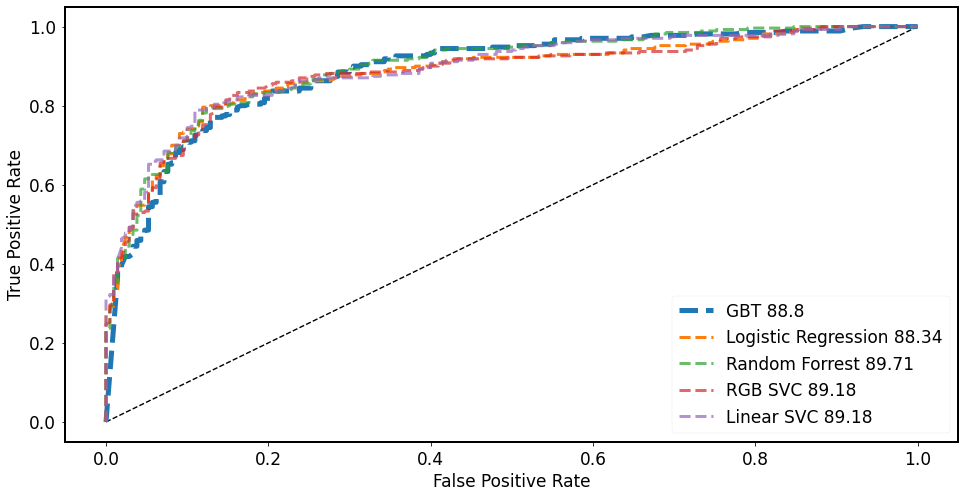

In [86]:
plt.rcParams['figure.figsize'] = [16, 8]
FONT_SIZE = 17

# plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 3, label = "DecisionTree(DT)")
# plt.plot(falsePositiveRateDtWithGridSearch, truePositiveRateDtWithGridSearch, linewidth = 3, label = "DTWithGridSearch")
# plt.plot(falsePositiveRateGb, truePositiveRateGb, linewidth = 3, label = "GradientBoostedTrees(GBT)")
plt.plot([0,1],[0,1], 'k--')
plt.plot(falsePositiveRateGbWithGridSearch, truePositiveRateGbWithGridSearch, linewidth = 5, label = "GBT " + str(gbtGridAUC), linestyle='--')
plt.plot(falsePositiveRateLR, truePositiveRateLR, linewidth = 3, label = "Logistic Regression " + str(lrAUC), linestyle='--')
plt.plot(falsePositiveRateRF, truePositiveRateRF, linewidth = 3, label = "Random Forrest " + str(rfAUC), alpha=.7, linestyle='--')
plt.plot(falsePositiveRateSVC, truePositiveRateSVC, linewidth = 3, label = "RGB SVC " + str(svcAUC), alpha=.7, linestyle='--')
plt.plot(falsePositiveRateLinearSVC, truePositiveRateLinearSVC, linewidth = 3, label = "Linear SVC " + str(svcAUC), alpha=.7, linestyle='--')
plt.legend(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
plt.show()

In [683]:
# return the indicies from the original dataframe that we used as features in our model
def findIndiciesOfFeatures(features, original):
    indicies = []
    originalCols = list(original.columns)
    for feature in features :
        if feature in originalCols:
            # print(feature)
            # print (originalCols.index(feature))
            indicies.append(originalCols.index(feature))
    if(indicies[-1] == 15):
        indicies.pop()
    return indicies

# Test above function..
print(np.array_equal(np.asarray(data.columns)[findIndiciesOfFeatures(dtCols,data)], dtCols[:-1]))
print(np.array_equal(np.asarray(data.columns)[findIndiciesOfFeatures(gbCols,data)], gbCols[:-1]))
print(np.array_equal(np.asarray(data.columns)[findIndiciesOfFeatures(lrCols,data)], lrCols))



True
True
True


In [684]:
# 0 'AnonymousID'
# 1 'HotelInncode'
# 2 'HotelBrand'
# 3 'HotelChainScale'
# 4 'Generation'
# 5 'Department'
# 6 'FullTimePartTime'
# 7 'Tenure'
# 8 'ManagementLevel'
# 9 'WorkLifeBalance'
# 10'LearningDevelopment'
# 11'Communication'
# 12'Voice'
# 13'RewardsBenefits'
# 14'WorkEnvironment'
# 15'IntentToStay'
# print(gbCols)
# print(dtCols)

In [685]:
# Read data into a data frame
testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))
# Delete null values
testDataForSubmission = testDataForSubmission.dropna()
# Convert data to a list of lists
testDataListForSubmission = testDataForSubmission.values.tolist()
# Get features
testFeaturesForSubmissionDT = []
testFeaturesForSubmissionGB = []
testFeaturesForSubmissionLR = []
# Decision Tree
indicies = findIndiciesOfFeatures(dtCols,data)
for row in testDataListForSubmission:
    # Skip the first two columns because they are not needed and the last column because that's the label
    nprow = np.asarray(row)
    # featureValues = nprow[[9,10,11,12,13,14]]
    featureValues = nprow[[indicies]]
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues]  
    # Append the features to the feature list
    testFeaturesForSubmissionDT.append(featureValues)

indicies = findIndiciesOfFeatures(gbCols,data)
for row in testDataListForSubmission:
    nprow = np.asarray(row)
    featureValues = nprow[[indicies]]
    # print(featureValues)
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues]  
    # Append the features to the feature list
    testFeaturesForSubmissionGB.append(featureValues)


indicies = findIndiciesOfFeatures(lrCols,data)
for row in testDataListForSubmission:
    nprow = np.asarray(row)
    featureValues = nprow[[indicies]]
    # print(featureValues)
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues]  
    # Append the features to the feature list
    testFeaturesForSubmissionLR.append(featureValues)

In [686]:
resultsFile = open("Results/rf.csv", "w")
resultsFile.write("Id,Expected\n")
for rfPredictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
    resultsFile.write(str(i + 1) + "," + str(rfPredictionProb[1]) + "\n")
resultsFile.close()

resultsFile = open("Results/gb.csv", "w")
resultsFile.write("Id,Expected\n")
for gbPredictionProb, i in zip(gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
    resultsFile.write(str(i + 1) + "," + str(gbPredictionProb[1]) + "\n")
resultsFile.close()

In [687]:
# resultsFile = open("Results/gb_lr.csv", "w")
# resultsFile.write("Id,Expected\n")
# for clfPredictionProb,gbPredictionProb, i in zip(clf.predict_proba(testFeaturesForSubmissionLR),gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
#     resultsFile.write(str(i + 1) + "," + str((float(gbPredictionProb[1])+float(clfPredictionProb[1]))/2) + "\n")
# resultsFile.close()


# resultsFile = open("Results/gb_lr_rf.csv", "w")
# resultsFile.write("Id,Expected\n")
# for rfPredictionProb,clfPredictionProb,gbPredictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmissionGB),clf.predict_proba(testFeaturesForSubmissionLR),gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
#     resultsFile.write(str(i + 1) + "," + str((float(rfPredictionProb[1])+float(clfPredictionProb[1])+float(gbPredictionProb[1]))/3) + "\n")
# resultsFile.close()

resultsFile = open("Results/gb_rf.csv", "w")
resultsFile.write("Id,Expected\n")
for rfPredictionProb,gbPredictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmissionGB),gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
    resultsFile.write(str(i + 1) + "," + str((float(rfPredictionProb[1])+float(gbPredictionProb[1]))/2) + "\n")
resultsFile.close()
    
print("All predictions have been placed in the results folder...")

All predictions have been placed in the results folder...


## 6.1 Top N Accuracy

In [688]:
def calculateClasswiseTopNAccuracy(model, TOP_N):
    """
    model is a trained model file such as gbClassifier, classifierDt
    TOP_N is the top n% predictions you want to use for each class
    """
    global testData
    predictionProbsTopN = model.predict_proba(testData)
    predictionsTopN = gbClassifier.predict(testData)
    predictionProbsTopNLeave, predictionProbsTopNStay = [item[0] for item in predictionProbsTopN], [item[1] for item in predictionProbsTopN]
    predictionProbsTopNLeave = list(reversed(sorted(predictionProbsTopNLeave)))[:int(len(predictionProbsTopNLeave) * TOP_N / 100)][-1]
    predictionProbsTopNStay = list(reversed(sorted(predictionProbsTopNStay)))[:int(len(predictionProbsTopNStay) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyLeave = []
    accuracyStay = []
    for i in range(0, len(predictionsTopN)):
        if predictionsTopN[i] == 1:
            # Staying
            if predictionProbsTopN[i][1] > predictionProbsTopNStay:
                accuracyStay.append(int(testLabels[i]) == 1)
        else:
            # Leave
            if predictionProbsTopN[i][0] > predictionProbsTopNLeave:
                accuracyLeave.append(int(testLabels[i]) == 0)

    accuracyStay = round((accuracyStay.count(True) * 100) / len(accuracyStay), 2)
    accuracyLeave = round((accuracyLeave.count(True) * 100) / len(accuracyLeave), 2)
    return accuracyLeave, accuracyStay

In [689]:
def calculateClasswiseTopNAccuracy(model, TOP_N):
    """
    model is a trained model file such as gbClassifier, classifierDt
    TOP_N is the top n% predictions you want to use for each class
    """
    global testData
    predictionProbsTopN = model.predict_proba(testData)
    predictionsTopN = gbClassifier.predict(testData)
    predictionProbsTopNLeave, predictionProbsTopNStay = [item[0] for item in predictionProbsTopN], [item[1] for item in predictionProbsTopN]
    predictionProbsTopNLeave = list(reversed(sorted(predictionProbsTopNLeave)))[:int(len(predictionProbsTopNLeave) * TOP_N / 100)][-1]
    predictionProbsTopNStay = list(reversed(sorted(predictionProbsTopNStay)))[:int(len(predictionProbsTopNStay) * TOP_N / 100)][-1]

    # Calculate accuracy for both classes
    accuracyLeave = []
    accuracyStay = []
    for i in range(0, len(predictionsTopN)):
        if predictionsTopN[i] == 1:
            # Staying
            if predictionProbsTopN[i][1] > predictionProbsTopNStay:
                accuracyStay.append(int(testLabels[i]) == 1)
        else:
            # Leave
            if predictionProbsTopN[i][0] > predictionProbsTopNLeave:
                accuracyLeave.append(int(testLabels[i]) == 0)

    accuracyStay = round((accuracyStay.count(True) * 100) / len(accuracyStay), 2)
    accuracyLeave = round((accuracyLeave.count(True) * 100) / len(accuracyLeave), 2)
    return accuracyLeave, accuracyStay

Accuracy for top 50 percent predictions for leave: 78.03, stay: 84.94
Accuracy for top 40 percent predictions for leave: 82.72, stay: 93.19
Accuracy for top 30 percent predictions for leave: 88.81, stay: 97.90
Accuracy for top 20 percent predictions for leave: 91.58, stay: 100.00
Accuracy for top 10 percent predictions for leave: 93.62, stay: 100.00


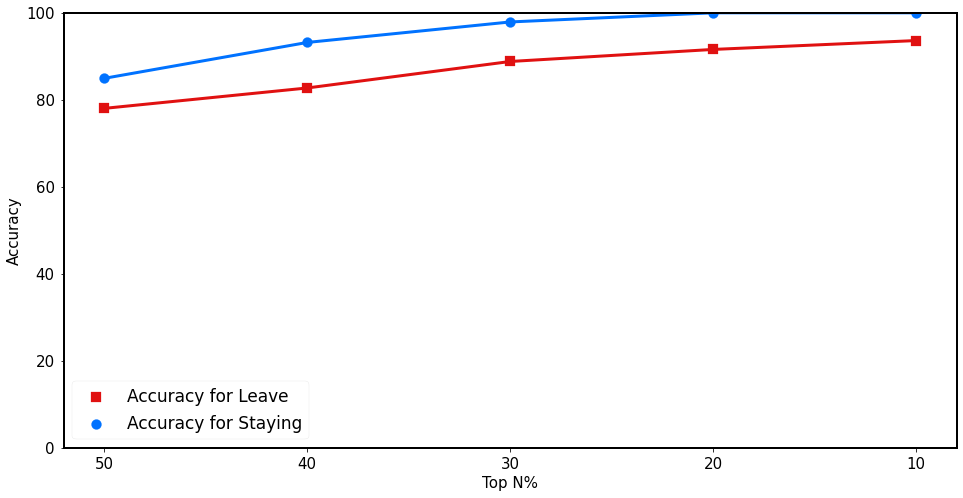

In [690]:
######################################################### You can change values in the list below ################################################
TOP_N_LIST = [50, 40, 30, 20, 10]
####################################################################################################################################################

accuraciesLeave, accuraciesStay = [], []
for n in TOP_N_LIST:
    accuracyLeave, accuracyStay = calculateClasswiseTopNAccuracy(gbClassifier, n)
    accuraciesLeave.append(accuracyLeave)
    accuraciesStay.append(accuracyStay)
    
    print("Accuracy for top %d percent predictions for leave: %.2f, stay: %.2f" % (n, accuracyLeave, accuracyStay))
    
# Plot results
x = np.arange(len(accuraciesLeave))
plt.plot(x, accuraciesLeave, linewidth = 3, color = '#e01111')
scatterLeave = plt.scatter(x, accuraciesLeave, marker = 's', s = 100, color = '#e01111')
plt.plot(x, accuraciesStay, linewidth = 3, color = '#0072ff')
scatterStay = plt.scatter(x, accuraciesStay, marker = 'o', s = 100, color = '#0072ff')
plt.xticks(x, TOP_N_LIST, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("Top N%", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend([scatterLeave, scatterStay], ["Accuracy for Leave", "Accuracy for Staying"], fontsize = 17)
plt.ylim(0, 100)
plt.show()



In [691]:
data.columns

Index(['AnonymousID', 'HotelInncode', 'HotelBrand', 'HotelChainScale',
       'Generation', 'Department', 'FullTimePartTime', 'Tenure',
       'ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment',
       'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment',
       'IntentToStay'],
      dtype='object')

[9, 13, 11, 10, 12, 14, 7, 4]
Index(['WorkLifeBalance', 'RewardsBenefits', 'Communication',
       'LearningDevelopment', 'Voice', 'WorkEnvironment', 'Tenure',
       'Generation'],
      dtype='object')
Feature Value = 1.0, Number of instances in data: 9
Accuracy: 100.00
PrecisionNegative: 100.00
PrecisionPositive: 100.00
RecallNegative: 100.00
RecallPositive: 100.00
AUC Score: 100.00



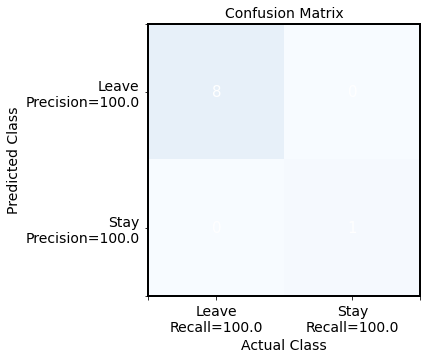

Feature Value = 1.7, Number of instances in data: 2
Accuracy: 100.00
PrecisionNegative: 100.00
PrecisionPositive: 100.00
RecallNegative: 100.00
RecallPositive: 100.00
AUC Score: 100.00



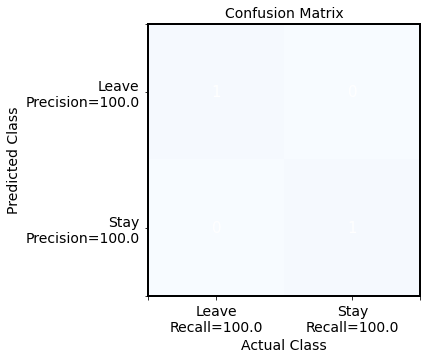

Feature Value = 2.0, Number of instances in data: 8
Accuracy: 75.00
PrecisionNegative: 75.00
PrecisionPositive: 0.00
RecallNegative: 100.00
RecallPositive: 0.00
AUC Score: 91.67



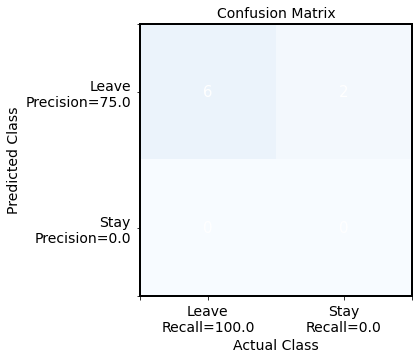

Feature Value = 2.3, Number of instances in data: 4
Accuracy: 100.00
PrecisionNegative: 100.00
PrecisionPositive: 100.00
RecallNegative: 100.00
RecallPositive: 100.00
AUC Score: 100.00



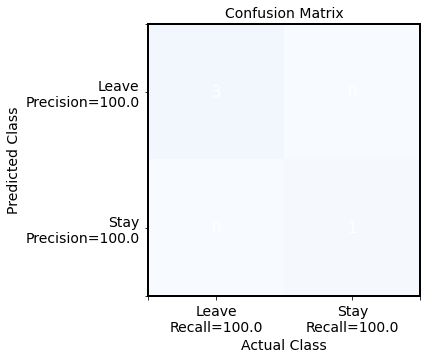

Feature Value = 2.7, Number of instances in data: 9


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [692]:
import collections
plt.rcParams['figure.figsize'] = [24, 8] ## plot size
columns = data.columns


def getFeatureWiseAccuracy(model, featureName, indicies):
    testPredictionsForFeatureSegmentation = model.predict(testData)
    testPredictionProbsForFeatureSegmentation = model.predict_proba(testData)
    testDataDataFrame = pd.DataFrame(testData)
    cols=np.asarray(columns)
    testDataDataFrame.columns = cols[[indicies]]
    print(testDataDataFrame.columns)
    # testDataDataFrame.columns = columns[2: -1]

            # nprow = np.asarray(row)
            # featureValues = nprow[[indicies]]

    featureValues = list(testDataDataFrame[featureName])
    uniqueValues = list(sorted(set(featureValues)))
    accuracyPerValue = collections.defaultdict(list)
    accuracyPerValueLeave = collections.defaultdict(list)
    accuracyPerValueStay = collections.defaultdict(list)
    for i in range(0, len(testLabels)):
        accuracyPerValue[featureValues[i]].append([int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]),
                                                    testLabels[i], testPredictionsForFeatureSegmentation[i], testPredictionProbsForFeatureSegmentation[i]])
        if testPredictionsForFeatureSegmentation[i] == 1:
            accuracyPerValueStay[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))
        else:
            accuracyPerValueLeave[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))

    accuracies, accuraciesStay, accuraciesLeave = [], [], []
    for value in uniqueValues:
        accuracyPerValueCounts = [item[0] for item in accuracyPerValue[value]]
        accuracy = round((accuracyPerValueCounts.count(True) * 100) / (len(accuracyPerValueCounts) + 1), 2) # 1 is added in the denominator for division by zero errors. Please leave it there.
        accuracyStay = round((accuracyPerValueStay[value].count(True) * 100) / (len(accuracyPerValueStay[value]) + 1), 2)
        accuracyLeave = round((accuracyPerValueLeave[value].count(True) * 100) / (len(accuracyPerValueLeave[value]) + 1), 2)
        #    print("Feature Value = %.1f, Overall Accuracy: %.2f, Accuracy for Staying: %.2f, Accuracy for Leaving: %.2f" % (value, accuracy, accuracyStay, accuracyLeave))
        print("Feature Value = %.1f, Number of instances in data: %d" % (value, len(accuracyPerValueCounts)))
    
        # Confusion matrices
        _predictions = [item[2] for item in accuracyPerValue[value]]
        _predictionsProbs = [item[3] for item in accuracyPerValue[value]]
        _testLabels = [item[1] for item in accuracyPerValue[value]]
        _ = calculateMetricsAndPrint(_predictions, _predictionsProbs, _testLabels)
        
        # Add to lists for plotting
        accuracies.append(accuracy), accuraciesStay.append(accuracyStay), accuraciesLeave.append(accuracyLeave)
    
    # Plotting
    plt.rcParams['figure.figsize'] = [16, 8]
    x = np.arange(len(accuracies))
    plt.plot(x, accuracies, linewidth = 3, color = '#53d100')
    scatterAcc = plt.scatter(x, accuracies, marker = 'x', s = 100, color = '#53d100')
    plt.plot(x, accuraciesLeave, linewidth = 3, color = '#e01111')
    scatterLeave = plt.scatter(x, accuraciesLeave, marker = 's', s = 100, color = '#e01111')
    plt.plot(x, accuraciesStay, linewidth = 3, color = '#0072ff')
    scatterStay = plt.scatter(x, accuraciesStay, marker = 'o', s = 100, color = '#0072ff')
    plt.xticks(x, uniqueValues, fontsize = 15, rotation = 90)
    plt.yticks(fontsize = 15)
    plt.xlabel("Feature Value for " + featureName, fontsize = 15)
    plt.ylabel("Accuracy", fontsize = 15)
    plt.legend([scatterAcc, scatterLeave, scatterStay], ["Overall Accuracy", "Accuracy for Leave", "Accuracy for Staying"], fontsize = 17)
    plt.ylim(0, 100)
    plt.show()
    
############################################## Add your feature name here ###################################
FEATURE_NAME = "Communication" # This has to be a valid feature name
#############################################################################################################
indicies=findIndiciesOfFeatures(gbCols,data)
print(indicies)
getFeatureWiseAccuracy(gbClassifier, FEATURE_NAME, indicies)

#If you want to segment every feature and get results, you can loop over the feature names as given in the next two lines.
#for col in columns[2:-1]:
#    getFeatureWiseAccuracy(gbClassifier, col)

In [694]:
# import collections
# plt.rcParams['figure.figsize'] = [24, 8] ## plot size

# def getFeatureWiseAccuracy(model, featureName):
#     testPredictionsForFeatureSegmentation = model.predict(testData)
#     testPredictionProbsForFeatureSegmentation = model.predict_proba(testData)
#     testDataDataFrame = pd.DataFrame(testData)
#     testDataDataFrame.columns = columns[2: -1]

#     featureValues = list(testDataDataFrame[featureName])
#     uniqueValues = list(sorted(set(featureValues)))
#     accuracyPerValue = collections.defaultdict(list)
#     accuracyPerValueLeave = collections.defaultdict(list)
#     accuracyPerValueStay = collections.defaultdict(list)
#     for i in range(0, len(testLabels)):
#         accuracyPerValue[featureValues[i]].append([int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]),
#                                                     testLabels[i], testPredictionsForFeatureSegmentation[i], testPredictionProbsForFeatureSegmentation[i]])
#         if testPredictionsForFeatureSegmentation[i] == 1:
#             accuracyPerValueStay[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))
#         else:
#             accuracyPerValueLeave[featureValues[i]].append(int(testLabels[i]) == int(testPredictionsForFeatureSegmentation[i]))

#     accuracies, accuraciesStay, accuraciesLeave = [], [], []
#     for value in uniqueValues:
#         accuracyPerValueCounts = [item[0] for item in accuracyPerValue[value]]
#         accuracy = round((accuracyPerValueCounts.count(True) * 100) / (len(accuracyPerValueCounts) + 1), 2) # 1 is added in the denominator for division by zero errors. Please leave it there.
#         accuracyStay = round((accuracyPerValueStay[value].count(True) * 100) / (len(accuracyPerValueStay[value]) + 1), 2)
#         accuracyLeave = round((accuracyPerValueLeave[value].count(True) * 100) / (len(accuracyPerValueLeave[value]) + 1), 2)
#         #    print("Feature Value = %.1f, Overall Accuracy: %.2f, Accuracy for Staying: %.2f, Accuracy for Leaving: %.2f" % (value, accuracy, accuracyStay, accuracyLeave))
#         print("Feature Value = %.1f, Number of instances in data: %d" % (value, len(accuracyPerValueCounts)))
    
#         # Confusion matrices
#         _predictions = [item[2] for item in accuracyPerValue[value]]
#         _predictionsProbs = [item[3] for item in accuracyPerValue[value]]
#         _testLabels = [item[1] for item in accuracyPerValue[value]]
#         _ = calculateMetricsAndPrint(_predictions, _predictionsProbs, _testLabels)
        
#         # Add to lists for plotting
#         accuracies.append(accuracy), accuraciesStay.append(accuracyStay), accuraciesLeave.append(accuracyLeave)
    
#     # Plotting
#     plt.rcParams['figure.figsize'] = [16, 8]
#     x = np.arange(len(accuracies))
#     plt.plot(x, accuracies, linewidth = 3, color = '#53d100')
#     scatterAcc = plt.scatter(x, accuracies, marker = 'x', s = 100, color = '#53d100')
#     plt.plot(x, accuraciesLeave, linewidth = 3, color = '#e01111')
#     scatterLeave = plt.scatter(x, accuraciesLeave, marker = 's', s = 100, color = '#e01111')
#     plt.plot(x, accuraciesStay, linewidth = 3, color = '#0072ff')
#     scatterStay = plt.scatter(x, accuraciesStay, marker = 'o', s = 100, color = '#0072ff')
#     plt.xticks(x, uniqueValues, fontsize = 15, rotation = 90)
#     plt.yticks(fontsize = 15)
#     plt.xlabel("Feature Value for " + featureName, fontsize = 15)
#     plt.ylabel("Accuracy", fontsize = 15)
#     plt.legend([scatterAcc, scatterLeave, scatterStay], ["Overall Accuracy", "Accuracy for Leave", "Accuracy for Staying"], fontsize = 17)
#     plt.ylim(0, 100)
#     plt.show()
    
# ############################################## Add your feature name here ###################################
# FEATURE_NAME = "WorkEnvironment" # This has to be a valid feature name
# #############################################################################################################
# getFeatureWiseAccuracy(gbClassifier, FEATURE_NAME, )

# #If you want to segment every feature and get results, you can loop over the feature names as given in the next two lines.
# #for col in columns[2:-1]:
# #    getFeatureWiseAccuracy(gbClassifier, col)

In [695]:
# ############################################
# # modelToExplain is the model you want to use for explanation
# modelToExplain = classifierDt ######### PLEASE DO NOT CHANGE THIS. SHAP PACKAGE CURRENTLY WORKS WITH DECISION TREES ONLY.
# ############################################
# #####################################
# # Index is the row number which you want to explain
# index = 100
# #####################################

# explainer = shap.TreeExplainer(modelToExplain)
# shapValues = np.array(explainer.shap_values(np.array(trainData)))

# # Convert to dataframe, that's what shapley package uses
# trainDataDf = pd.DataFrame(trainData)
# trainDataDf.columns = columns[2:-1]

# print("Creating the plot for explaining the instance for 'STAY'...")
# print("The output is the prediction probability for label 'STAY'. Please keep that in mind when looking at the plot below.")
# shap.force_plot(explainer.expected_value[1], shapValues[1][index,:], trainDataDf.iloc[index,:])

In [696]:
# ############################################
# # modelToExplain is the model you want to use for explanation
# modelToExplain = classifierDt ######### PLEASE DO NOT CHANGE THIS. SHAP PACKAGE CURRENTLY WORKS WITH DECISION TREES ONLY.
# ############################################
# #####################################
# # Index is the row number which you want to explain
# index = 100
# #####################################

# explainer = shap.TreeExplainer(modelToExplain)
# shapValues = np.array(explainer.shap_values(np.array(trainData)))

# # Convert to dataframe, that's what shapley package uses
# trainDataDf = pd.DataFrame(trainData)
# trainDataDf.columns = columns[2:-1]

# print("Creating the plot for explaining the instance for 'STAY'...")
# print("The output is the prediction probability for label 'STAY'. Please keep that in mind when looking at the plot below.")
# shap.force_plot(explainer.expected_value[1], shapValues[1][index,:], trainDataDf.iloc[index,:])

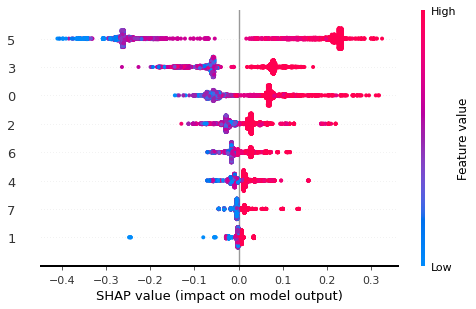

In [697]:
shap.summary_plot(shapValues[1], trainDataDf)